# <font size="10"> Group 27 Project Report </font> 

**Team Members** Khushi Narang, Mengen Liu, Rosha Mehrad, Yilin Long   

# Libraries

In [ ]:
library(tidyverse)
library(tidymodels)
library(repr)
library(httr)
library(readxl)
library(ggplot2)
library(GGally)
library(rsample)
install.packages("themis")
library(themis)
install.packages("ggcorrplot")
library(ggcorrplot)
install.packages("kknn")

# Introduction

Neutron stars called pulsars are a rare occurrence that occasionally produce audible radio transmissions on Earth. Due to their ability to provide light on space-time, the interstellar medium, and states of matter, these stars have great value for scientific inquiry (see [2] for more uses).

<img src='https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif' width='400'>

Source: https://media.giphy.com/media/l3dj5M4YLaFww31V6/giphy.gif

Although each pulsar releases a distinctive pattern of radio signals that differs with each spin, during observation, prospective signals, or "candidates," are averaged over several rotations. Each contender may represent a genuine pulsar in the absence of more information. It is difficult to distinguish between real signals (pulsars) and false positives (noise), as the great majority of detections are brought on by noise and radio frequency interference (RFI).

In this case study, we seek to find an answer to "Can pulsar radio emissions be accurately distinguished from radio frequency interference (RFI) and radio noise?" The dataset that will be used is HTRU2, a set of data that lists a selection of pulsar candidates discovered as part of the High Time Resolution Universe Survey (South). It includes both fake and authentic samples of pulsars.

To do this, we must examine the signals' statistical and observational data (we refer to them as candidates in many places).

The data set's columns are represented in the graphic below.

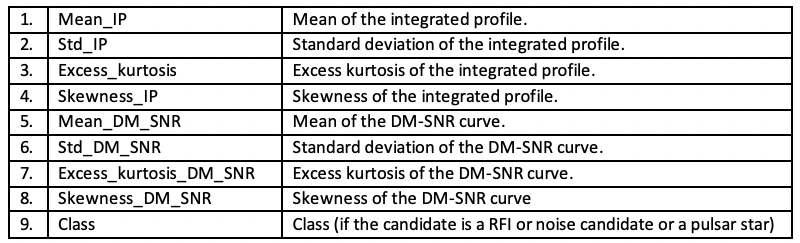

### Restating the question we would like to answer:
 **<font size="3"> Can pulsar radio emissions be accurately differentiated from radio frequency interference (RFI) and radio noise? </font>**

Before we begin, below lists all the libraries which will be used on this project:

# Methods & Results
### Loading data from the original source on the web 

In order to better comprehend the data we are working with, our first step is to import, manipulate, and examine the data using visualizations. The tidyverse package that we'll need for our analysis is first loaded.

In [2]:
# read the dataset
# Downloaded the zipped Pulsar data from URL
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
GET(URL, write_disk(tf <- tempfile(fileext = ".zip")))

# Unzip the tempfile and read the csv inside it
pulsar_data <- read_csv(unz(tf, "HTRU_2.csv"), col_names=FALSE)
head(pulsar_data)

Response [https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip]
  Date: 2023-04-14 21:41
  Status: 200
  Content-Type: application/x-httpd-php
  Size: 1.56 MB
<ON DISK>  /tmp/RtmpBCsBmk/file30bf1cf940c7.zipNULL

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


**Table 1**:

Analysis here:

### Cleaning and wrangling the data into a tidy format

We observed that column names were not present in the dataset. Therefore, we first wrangled the data by adding the columns names and write to modify the csv file. Also, the class column used 0 to represent RFI noise and 1 to represent pulsar. We also mutated the target class to be more meaningful value for a human.

In [3]:
# add column names using rename
pulsar_data <- rename(pulsar_data, Mean_IP=X1,Std_IP=X2, Excess_kurtosis_IP=X3, Skewness_IP=X4,
                     Mean_DM_SNR=X5, Std_DM_SNR=X6, Excess_kurtosis_DM_SNR=X7, Skewness_DM_SNR=X8, Class=X9)|>

# mutate the class to a more meaningful value for a human instead of 0 and 1
               mutate(Class = as_factor(case_when(Class == 1 ~ "pulsar",
                                                TRUE ~ "rfi_noise")))

head(pulsar_data)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,rfi_noise
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,rfi_noise
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,rfi_noise
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise


**Table 2**:

Analysis here:The dataset appears to contain observations of astronomical phenomena, with several features related to the integrated profile (IP) and the DM-SNR curve. The IP features include the mean and standard deviation, as well as measures of excess kurtosis and skewness. Similarly, the DM-SNR curve features include the mean and standard deviation, as well as measures of excess kurtosis and skewness.

### Splitting into training and testing data
It is imprtant to split the data before proceeding any further. This is because including your testing data in data analysis may influence our predictor/k value selection. For this data set, we decided to perform a split of 80/20 train/test.

In [4]:
set.seed(2) # set the random seed
pulsar_split <- initial_split(pulsar_data, prop = 0.8, strata = Class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

head(pulsar_test)
head(pulsar_train)

Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,rfi_noise
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,rfi_noise
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,rfi_noise
130.38281,39.84406,-0.15832276,0.3895404,1.220736,14.37894,13.539456,198.23646,rfi_noise
107.25000,52.62708,0.45268802,0.1703474,2.331940,14.48685,9.001004,107.97251,rfi_noise
133.25781,44.05824,-0.08105986,0.1153615,1.632107,12.00781,11.972067,195.54345,rfi_noise


Mean_IP,Std_IP,Excess_kurtosis_IP,Skewness_IP,Mean_DM_SNR,Std_DM_SNR,Excess_kurtosis_DM_SNR,Skewness_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,55.68378,-0.23457141,-0.6996484,3.1998328,19.110426,7.975532,74.24222,rfi_noise
102.5078,58.88243,0.46531815,-0.5150879,1.6772575,14.860146,10.576487,127.39358,rfi_noise
103.0156,39.34165,0.32332837,1.0511644,3.1212375,21.744669,7.735822,63.17191,rfi_noise
119.4844,48.76506,0.03146022,-0.1121676,0.9991639,9.279612,19.206230,479.75657,rfi_noise
107.2578,39.49649,0.46588196,1.1628771,4.0794314,24.980418,7.397080,57.78474,rfi_noise
142.0781,45.28807,-0.32032843,0.2839525,5.3762542,29.009897,6.076266,37.83139,rfi_noise


**Table 3**:

The `initial_split()` function from the rsample package is used here to split the data into training and testing sets. The prop argument specifies the proportion of data to assign to the training set (in this case, 80%). The strata argument is used to ensure that both the pulsar and RFI noise classes are represented proportionally in both the training and testing sets.

The `training()` and `testing()` functions from the same package are used to extract the training and testing data sets, respectively.

`head(pulsar_test)` and `head(pulsar_train)` display the first few rows of the testing and training sets, respectively.

Next, we will calculate the number and percentage of samples in each class in the training dataset using the group_by and summarize functions from the dplyr package. The resulting table shows the count and percentage of samples for each class.

### Summarizing the training data in a table

In [5]:
num_obs <- nrow(pulsar_train)
pulsar_train |>
  group_by(Class) |>
  summarize(
    count = n(),
    percentage = n() / num_obs * 100)

Class,count,percentage
<fct>,<int>,<dbl>
rfi_noise,13003,90.815756
pulsar,1315,9.184244


**Table 4**: Table showing the number and percentage of observations in each class

### Centering and scaling and Balancing the data

* **Centering and scaling**: It can be seen from Table 2 that some variables have a different scale compared to others. Any variables with a big scale will have a significantly larger effect than variables with a small scale since the classifier predicts classes by finding observations closest to it. But just because a variable has a large scale doesn’t mean that it is more important for making accurate predictions. Therefore, in the following code, we have scaled and centered our data set using `step_center(all_predictors())` and `step_scale(all_predictors())`. 
* **Balancing**: The pulsar data is tidy, but it suffers from a large class imbalance, as we can see from Table 1. Only about 9% of our dataset is classified as a pulsar. This can be a significant source of error in a final KNN model if it is not addressed in the training data processing. Hence, it is important to upsample our data set to make sure it is balanced across the classes (has roughly equal numbers of observation for each class). Belowe, we used `step_upsample(Class, over_ratio = 1, skip = FALSE) `to balance the dataset by oversampling the minority class.

Warning message:
“The dot-dot notation (`..count..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(count)` instead.”


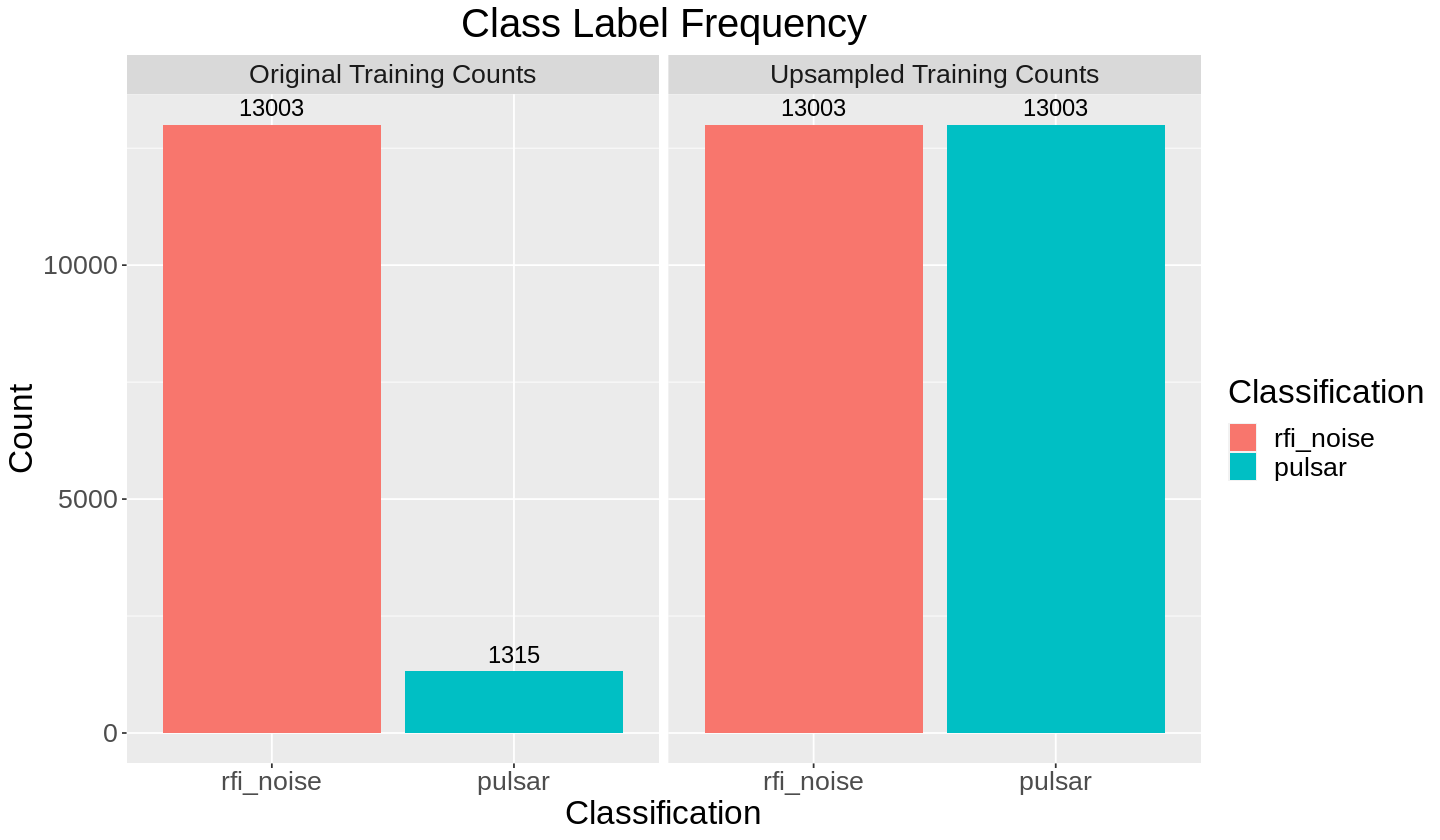

In [6]:
options(repr.plot.width = 12, repr.plot.height = 7)

# create an upsample recipe to account for the class imbalance in the original data set
pulsar_scaled_recipe <- recipe(Class ~ ., data = pulsar_train) |>
  step_center(all_predictors()) |>
  step_scale(all_predictors()) 
  
pulsar_upsample_recipe <- pulsar_scaled_recipe |> 
      step_upsample(Class, over_ratio = 1, skip = FALSE)
  
# prepped training data only scaled
pulsar_train_prepped_scaled <- pulsar_scaled_recipe |> 
                        prep() |>
                        bake(pulsar_train)

# prepped training data scaled and upsampled
pulsar_train_prepped_upsampled <- pulsar_upsample_recipe |> 
                        prep() |>
                        bake(pulsar_train)

# merging the original and upsampled data for side-by-side plotting and comparing purposes
join_by = c("Mean_IP", "Std_IP", "Excess_kurtosis_IP", "Skewness_IP",
                     "Mean_DM_SNR", "Std_DM_SNR", "Excess_kurtosis_DM_SNR", "Skewness_DM_SNR", "Class", "is_prepped")

# created this only for plotting purposes
pulsar_train_prepped_merge <- full_join(pulsar_train |> mutate(is_prepped = FALSE), 
                                    pulsar_train_prepped_upsampled |> mutate(is_prepped = TRUE),
                                     by = join_by)


upsample_compare_bar_plot <- pulsar_train_prepped_merge |> 
                        ggplot(aes(x = Class, fill = Class)) + 
                            geom_bar() +
                            labs(x = "Classification", 
                                 y = "Count",
                                 fill = "Classification") +
                            geom_text(stat='count', aes(label=..count..), vjust = -0.5, size=5) +
                            ggtitle("Class Label Frequency") +
                            theme(text = element_text(size=20),
                                  plot.title = element_text(hjust = 0.5)) +
                            facet_wrap(~ is_prepped,
                                   labeller = labeller(is_prepped = c("TRUE" = "Upsampled Training Counts", 
                                                                      "FALSE" = "Original Training Counts")))
upsample_compare_bar_plot  

**Figure 1**: Effect of Upsampling using original and upsampled training data on the frequency of each class

Here we can see that the majority of the classes are noises without stepping up the sample on Class. Precisely 13003 non-pulsar and 1315 pulsar. Now we can procede to the next step, visualizing data

### Visualizing our data to investigate and understand

# ADD TEXT HERE

Before we begin with any modelling, let's investigate our data collection! First, we need to explore and understand the relationships between variables provided by the HTRU2 dataset. We used data analysis techniques, such as visualization tools, to identify patterns, trends, and outliers in the data.

**Note:** Here, we used only scaled and centered data and not the upsampled data.

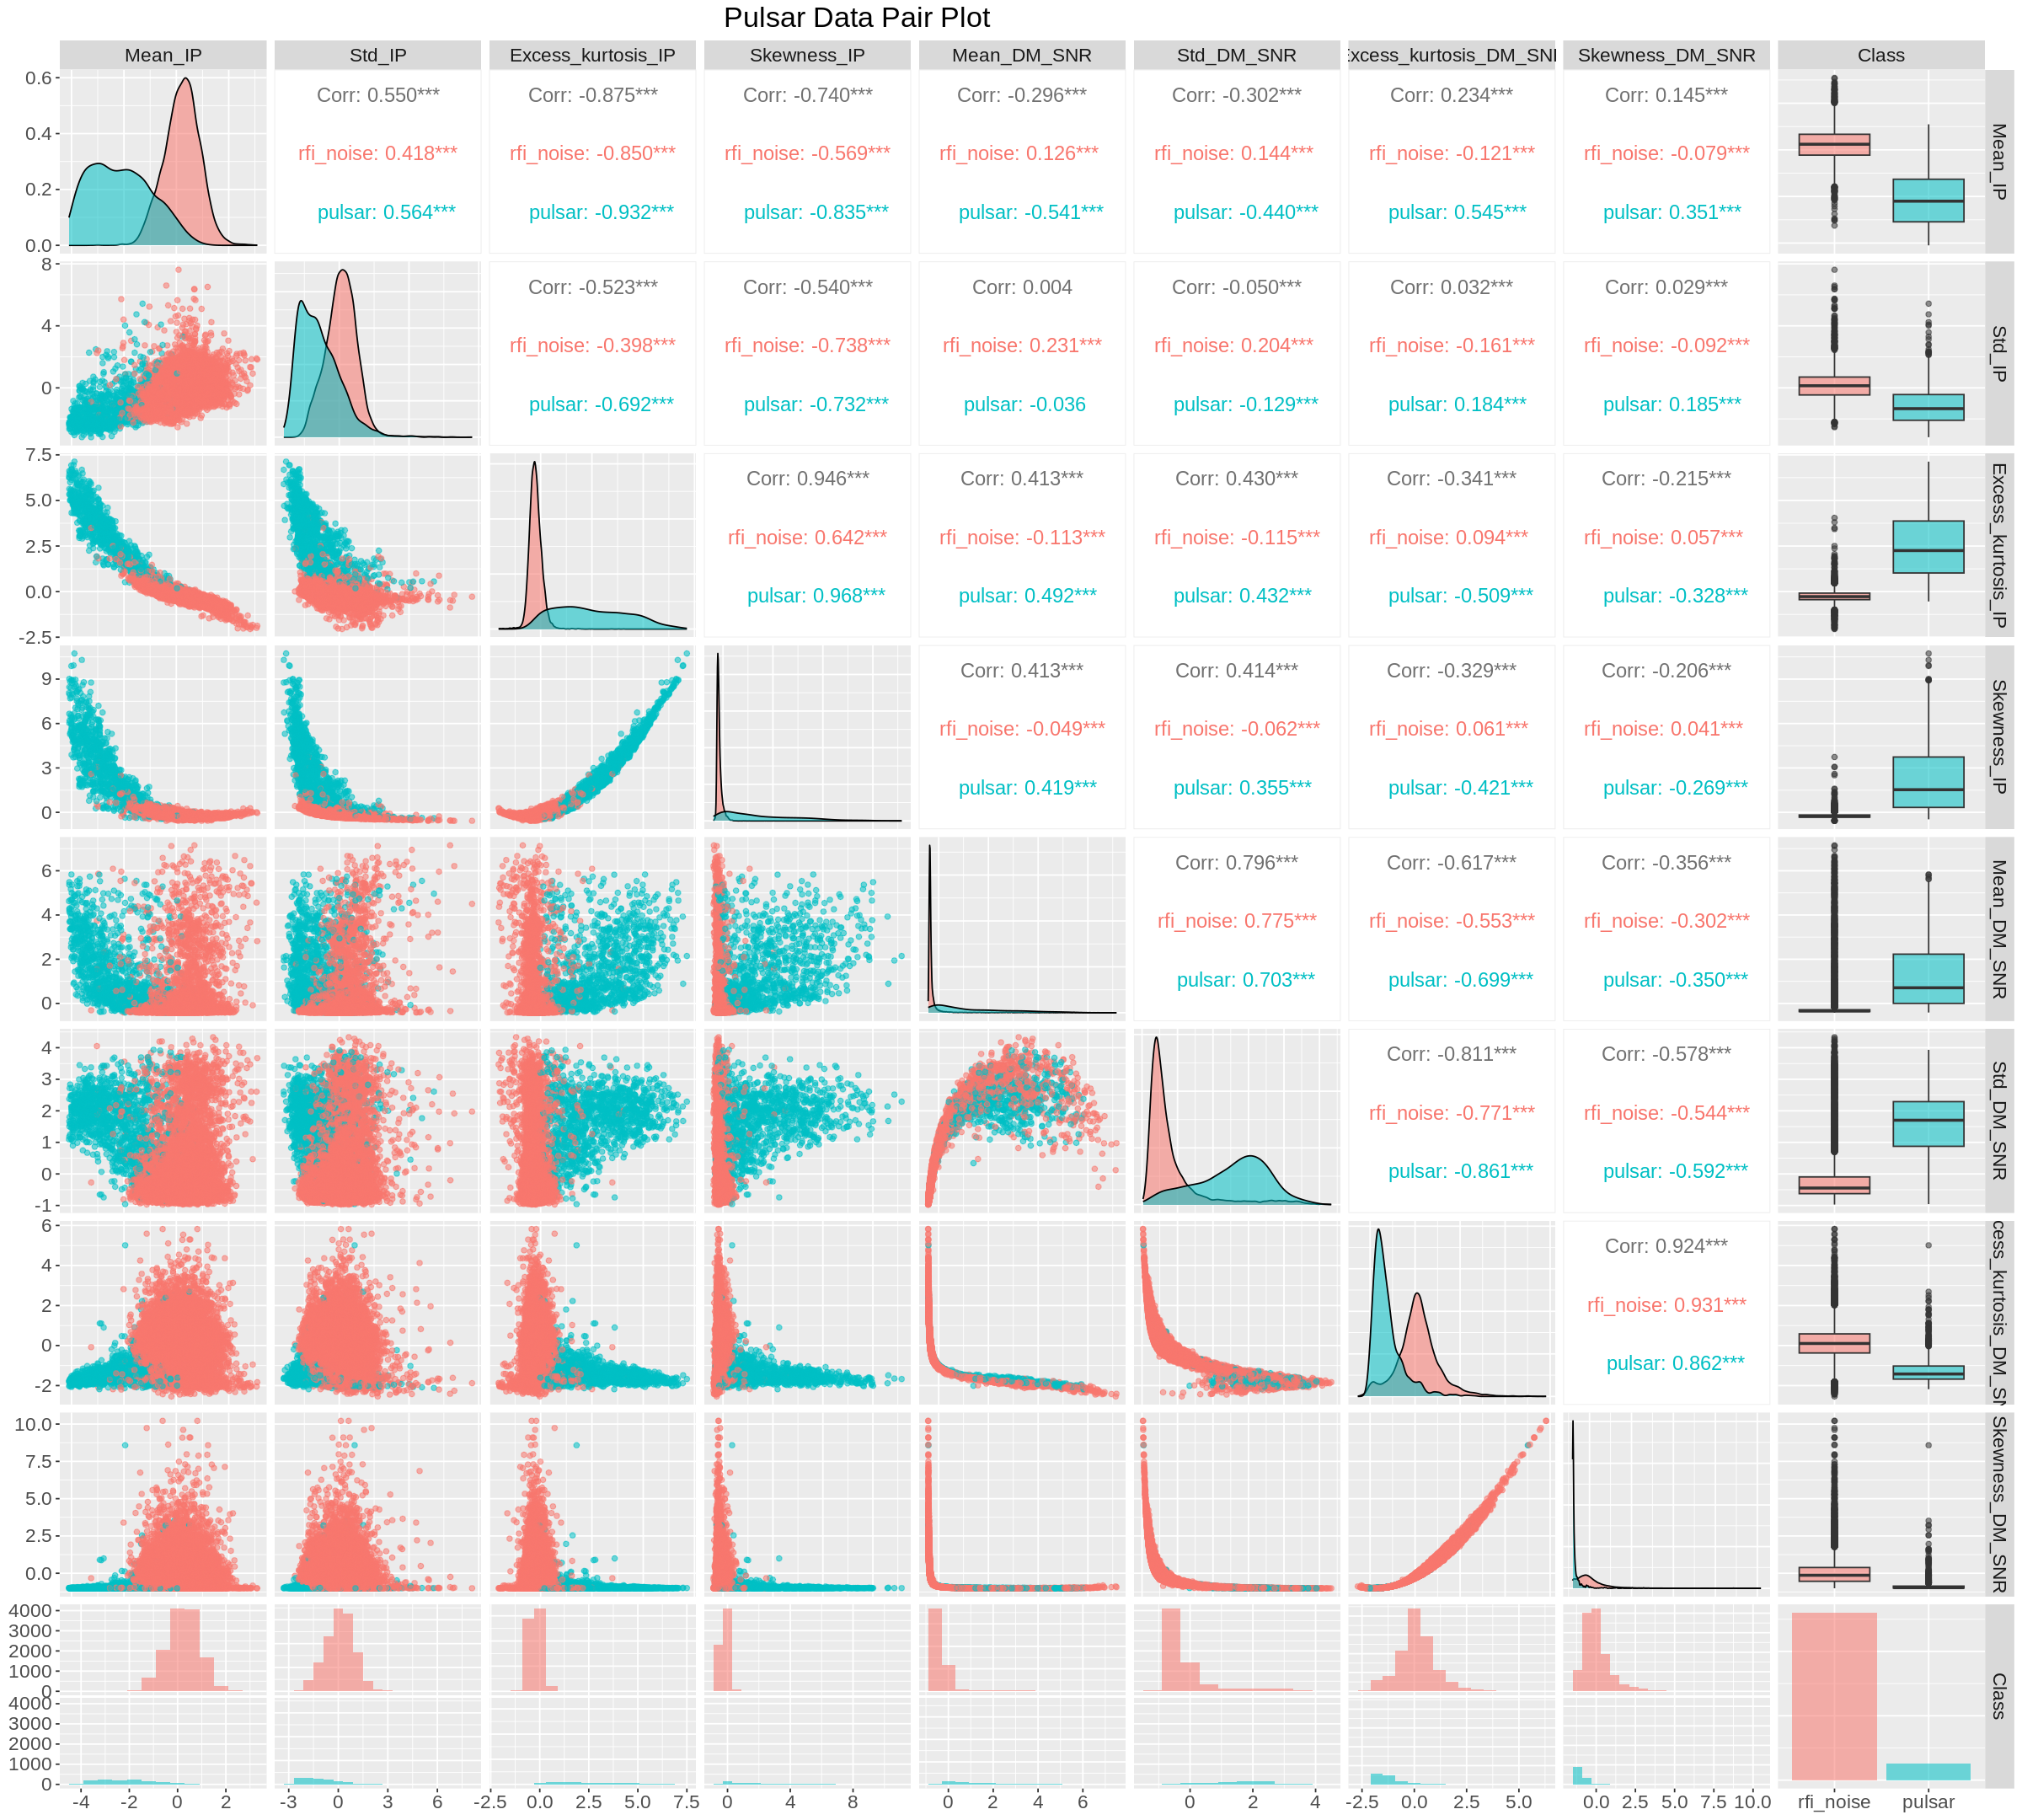

In [7]:
options(repr.plot.width = 20, repr.plot.height = 18)
 
# used the scaled data


ggpairs(pulsar_train_prepped_scaled,
           mapping = aes(color=Class, alpha = 0.3),
           lower=list(combo=wrap("facethist", binwidth=0.6)),
           upper=list(continuous = wrap("cor", size=5))) +
        ggtitle("Pulsar Data Pair Plot") +
        theme(text = element_text(size = 17),
              plot.title = element_text(hjust = 0.4))

**Figure 2**:

From the graph, we can tell the variables "
mean_dm_snr", "excess_kurtosis_dm_snr", “Std_DM_SNR” "skewness_dm_snr" are features that describe the shape and statistical properties of the signal intensity as a function of time, known as the dynamic spectrum. These features are based on the signal-to-noise ratio (SNR) of the dynamic spectrum and its statistical properties.[1][2]
**we will not include "mean_dm_snr", "excess_kurtosis_dm_snr", and "skewness_dm_snr" in our model as these variables do not provide good demarcation of Class when plotted against the other variables**.
However, in this particular dataset, we observe that these variables do not provide a clear separation between pulsars and radio noise when plotted against the other variables. This suggests that the SNR-based features may not be sufficient to distinguish pulsars from radio noise in this dataset, and other features may need to be considered.

Overall, the decision to exclude these variables from the model was based on their low discriminative power, as revealed by the exploratory data analysis.

To further investigate this matter, we will determine the correlation between each of the variables. To do this, we need `ggcorrplot` package must be installed then loaded (which has already been done). To calculate the correlation matrix, `cor()` function is used, but firstly, we need to remove the Class variable from it. Then, use `ggcorrplot()` function for a better visualization of the correlation matrix:

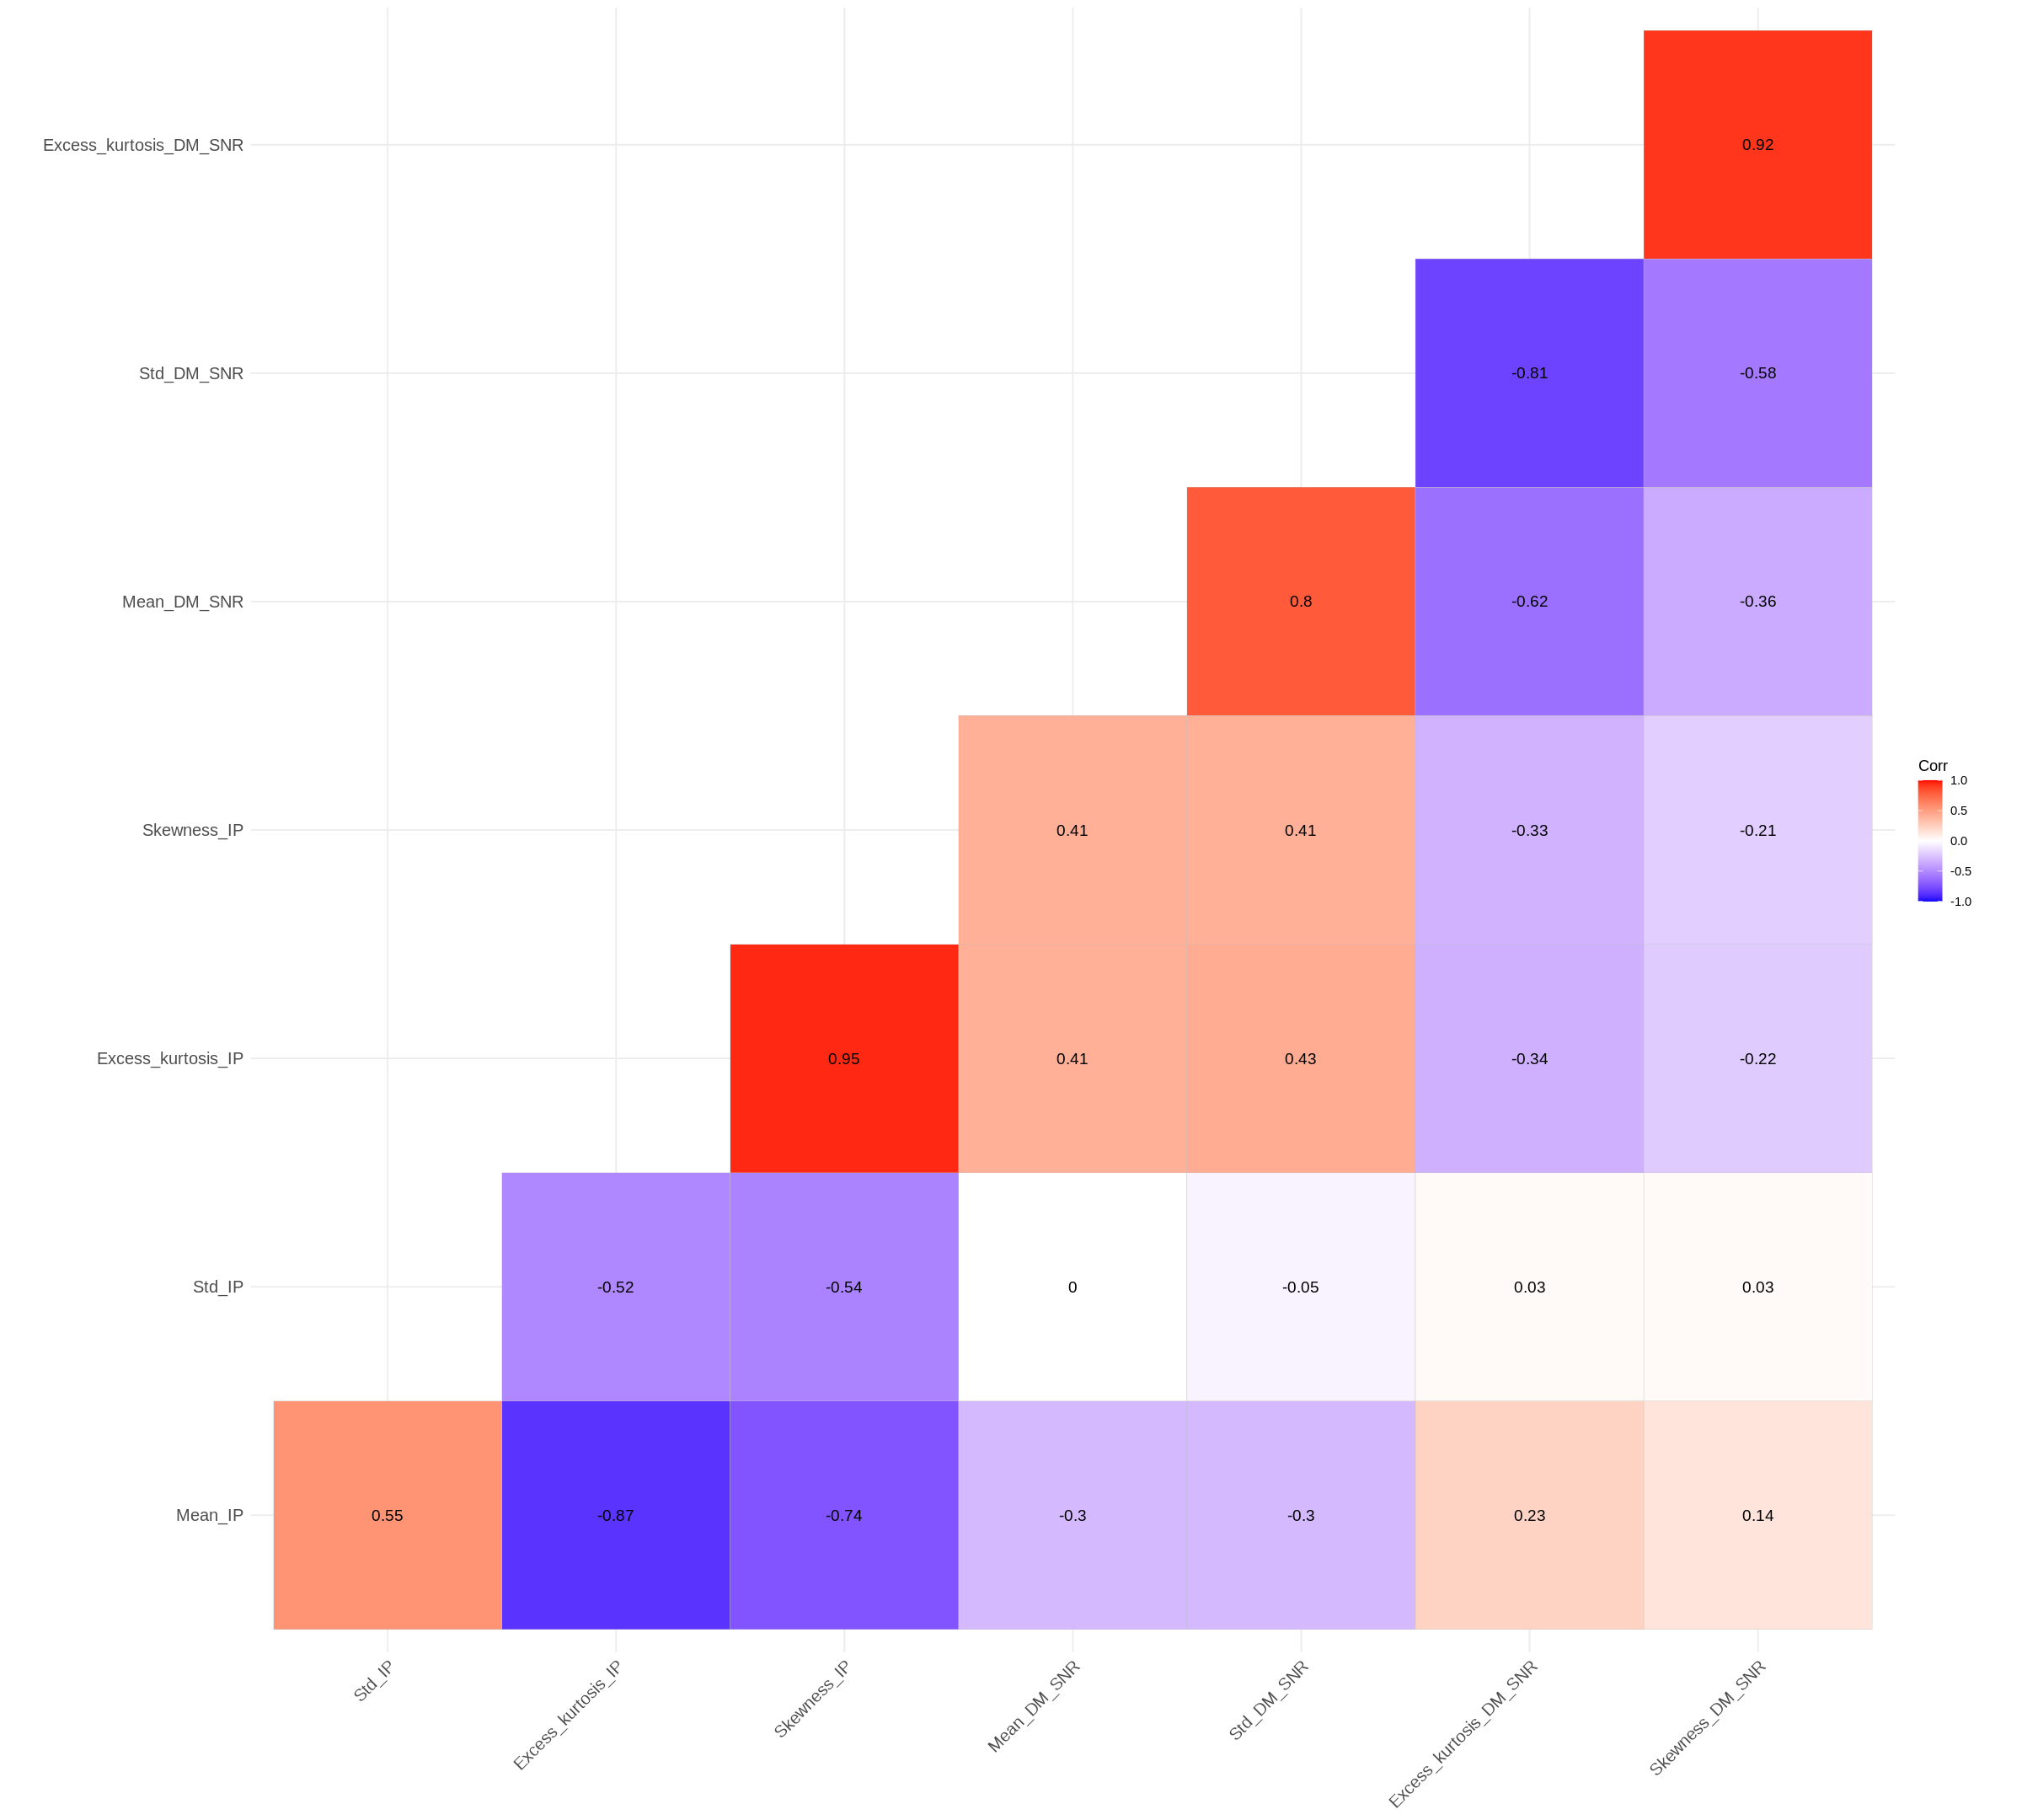

In [8]:
# Calculate correlation matrix
cor_matrix <- cor(select(pulsar_train_prepped_scaled, -Class))

# Visualize correlation matrix
ggcorrplot(cor_matrix, type = "lower", lab = TRUE)

**Figure**:

Here we have calculated the sum of all the correlation of each predictor, this will give us a better insight of which predictors are less dominant in the classsification of pulsars. This is done by taking the absolute value using the function `abs()` of the correlations of each potential predictor and added them with `colSums()` function. Then, we have sorted the list in decreasing order using `sort()`

* **Std_IP**
* **Skewness_DM_SNR**
* **Excess_kurtosis_DM_SNR**
* **Mean_DM_SNR**

Now, let's actually remove them from our subsets of data

In [9]:
pulsar_train <- select(pulsar_train, -Std_IP, -Skewness_DM_SNR, -Excess_kurtosis_DM_SNR, -Mean_DM_SNR)
head(pulsar_train)

Mean_IP,Excess_kurtosis_IP,Skewness_IP,Std_DM_SNR,Class
<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.5625,-0.23457141,-0.6996484,19.110426,rfi_noise
102.5078,0.46531815,-0.5150879,14.860146,rfi_noise
103.0156,0.32332837,1.0511644,21.744669,rfi_noise
119.4844,0.03146022,-0.1121676,9.279612,rfi_noise
107.2578,0.46588196,1.1628771,24.980418,rfi_noise
142.0781,-0.32032843,0.2839525,29.009897,rfi_noise


**Table**:

This dataset contains a subset of the features from the original dataset, which include Mean_IP, Excess_kurtosis_IP, Skewness_IP, Std_DM_SNR, and Class.

To get a better insight of the individual datapoints of out data sets we will use the group_by(), summarise(), and n() functions are used below to calculate the quantity and proportion of noise and pulsar observations in our data set. When combined with group by, the n function in summarise counts the number of observations in each Class group. The proportion in each category is then determined by dividing the total number of observations. Like such:

 in order to determine the optimum 
 parameter for our nearest neighbor classification. In order to avoid ties, we evaluate the odd values 
 since KNN will use a simple majority to select the class label and we have only two classes.



In [13]:
set.seed(2)
#kknn specification with euclidean distance
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbor = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
# set 5 folds 
pulsar_vfold <- vfold_cv(pulsar_train, v = 5 , strata = Class)

# cross validation to find accuracy of different k neighbors when using specified variables as predictors
optimum_recipe <- recipe(Class ~ Mean_IP + Excess_kurtosis_IP + Skewness_IP +
                                          Std_DM_SNR, data = pulsar_train) |> 
                        step_center(all_predictors()) |> 
                        step_scale(all_predictors()) |> 
                        step_upsample(Class, over_ratio = 1)

gridvals <- tibble(neighbors = seq(1, 15, by = 2))

knn_results <- workflow() |>
    add_recipe(optimum_recipe) |> 
    add_model(knn_spec) |>
    tune_grid(resamples = pulsar_vfold, grid = gridvals)  |>
    collect_metrics() 

knn_results

# filter to the accuracies of each neighbor
accuracy_estimates <- knn_results |>
              filter(.metric %in% c("accuracy"))
accuracy_estimates

ERROR: Error in set_mode(set_engine(nearest_neighbor(weight_func = "rectangular", : could not find function "set_mode"


Standardization involves centering the data around zero and scaling it to have unit variance. This step is important for some machine learning algorithms, including KNN, to ensure that all features are treated equally.

After standardizing the data, we will create our KNN model using the nearest_neighbor function. We will use neighbors= `tune()` function, to specify the number as the tuning parameter, which allows the optimization when training our model.

Analysis:The code defines a k-nearest neighbor (k-NN) classification model with rectangular weight function and an unspecified number of neighbors. It sets the kknn engine and classification mode for the model.

The workflow() function is used to create a modeling workflow, to which the data recipe and the k-NN model specification are added. Finally, the fit() function is called to train the model on the pulsar_train dataset.

The output is the trained knn_fit object, which can be used to make predictions on new data.

#### Accuracy of k-neighbours

Now, we can evaluate the precision of our classifier by utilizing the "metrics" function provided by the tidymodels package to obtain relevant statistics pertaining to the effectiveness of our model.

In [ ]:
options(repr.plot.width = 5, repr.plot.height = 5)

accuracy_vs_k <- ggplot(accuracy_estimates, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  scale_x_continuous(breaks = seq(1, 15, by = 2)) + 
  scale_y_continuous(limits = c(0.9 , 1.0)) +
  theme(text = element_text(size = 12))

accuracy_vs_k

#### Roc_auc metric of k-neighbours (what can this metric tell us???)

The Receiver Operator Characteristic (ROC) curve is a way to measure how well a model can distinguish between two categories, such as whether an email is spam or not. It plots two values, TPR and FPR, at different thresholds to show how well the model is able to identify positive cases and avoid false positives. The ROC curve is like a roadmap that helps you choose the best threshold for your model based on how well it performs. The Area Under the Curve (AUC) is a measure of how good the model is at telling apart the two categories and summarizes the ROC curve's performance.[8]

In [ ]:
roc_auc_vs_k <- ggplot(roc_auc, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "ROC-AUC Estimate") + 
  theme(text = element_text(size = 12))

accuracy_vs_k

### Picking the optimal k value

Here is the plot that will allow us better visualization to determine whether our chosen k is not underfitter or overfitted

In [ ]:

# create the grid of area/smoothness vals, and arrange in a data frame
are_grid <- seq(min(unscaled_cancer$Area), 
                max(unscaled_cancer$Area), 
                length.out = 100)
smo_grid <- seq(min(unscaled_cancer$Smoothness), 
                max(unscaled_cancer$Smoothness), 
                length.out = 100)
asgrid <- as_tibble(expand.grid(Area = are_grid, 
                                Smoothness = smo_grid))

# use the fit workflow to make predictions at the grid points
knnPredGrid <- predict(knn_fit, asgrid)

# bind the predictions as a new column with the grid points
prediction_table <- bind_cols(knnPredGrid, asgrid) |> 
  rename(Class = .pred_class)

# plot:
# 1. the colored scatter of the original data
# 2. the faded colored scatter for the grid points
wkflw_plot <-
  ggplot() +
  geom_point(data = unscaled_cancer, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.75) +
  geom_point(data = prediction_table, 
             mapping = aes(x = Area, 
                           y = Smoothness, 
                           color = Class), 
             alpha = 0.02, 
             size = 5) +
  labs(color = "Diagnosis", 
       x = "Area (standardized)", 
       y = "Smoothness (standardized)") +
  scale_color_manual(labels = c("Malignant", "Benign"), 
                     values = c("orange2", "steelblue2")) +
  theme(text = element_text(size = 12))

wkflw_plot

Additionally, we have the ability to examine the confusion matrix for the classifier. This matrix displays the predicted labels in comparison to the actual or correct labels and can be obtained through the use of the `conf_mat()`  function.

In [ ]:
confusion <- knn_results |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion

confusion <- knn_results |>
             conf_mat(truth = Class, estimate = .pred_class)
confusion### Prediction time

One of the important features of a well build model allows to predict future new frequency emmisions and be able to distinguish between noise and pulsar. To do this we will create a new observation using `tibble()` function and set each parameter like below: 



In [ ]:
# fix
fail()

new_observation <- tibble(Area = c(500, 1500), Smoothness = c(0.075, 0.1))
prediction <- predict(knn_fit, new_observation)

prediction

The code below will allow you to make your own observation. Just edit the following parameters (____, ____, _____,...):

In [ ]:
_________ <- 
_________ <-
_________ <-


new_observation <- tibble( Area = ____ , Smoothness = c(0.075, 0.1))
prediction <- predict(knn_fit, new_observation)

prediction

### Discussion

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
Discuss the limitations of this and what can be done in the future?

* Limitations: We need to do a better job in finding a good subset of predictors rather than just looking at a correlation graph. Even though it provides a good insight.

**Impact of findings**

Predicting pulsars has significant implications for both astrophysics and technology.

* Astrophysics[3]: Pulsars are dense, rapidly rotating neutron stars that emit beams of radiation. Predicting the locations of pulsars can help astronomers plan observations and study the properties of these objects in more detail.

* Gravitational waves[4]: Pulsars are also important for detecting gravitational waves, which are ripples in space-time caused by the motion of massive objects.    Knowing the locations of pulsars can help astronomers identify potential sources of gravitational waves and improve their chances of detecting them.

* Navigation: Pulsars could also be used for space navigation.      They are extremely regular in their emission, so they can be used as a kind of cosmic clock to help spacecraft navigate through the solar system and beyond.

**Future Questions**


### References

[1] R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656

[2] D. R. Lorimer and M. Kramer, "Handbook of Pulsar Astronomy", Cambridge University Press, 2005.

[3] Pulsars, transients and relativistic astrophysics. (2023, April 5) University of Oxford Department of Physics.. Retrieved April 10, 2023

[4] Listening for Gravitational Waves Using Pulsars. (2023). NASA. https://www.nasa.gov/feature/jpl/listening-for-gravitational-waves-using-pulsars

[5]https://astronomy.swin.edu.au/cosmos/p/pulsar+dispersion+measure#:~:text=In%20pulsar%20astronomy%20a%20handy,an%20observer%20and%20a%20pulsar%E2%80%9D.
[6] https://www.physics.mcgill.ca/~rlynch/Outreach/PSC_search_guide.pdf
[7]https://www.physics.ox.ac.uk/research/group/pulsars-transients-and-relativistic-astrophysic

[8] https://www.analyticsvidhya.com/blog/2020/06/auc-roc-curve-machine-learning/#:~:text=The%20ROC%20AUC%20score%20tells,and%20the%20Negative%20class%20points.

